## Modeling and Model Evaluation: Using `Pipelines`, `CountVectorizer`, `GridSearchCV`, and `NaïveBayes`.
*citation:* GA Lesson 6.04

In this analysis, I'll employ a powerful combination of techniques to model and predict text data. First, I'll construct a Pipeline and leverage GridSearchCV to fine-tune the parameters of CountVectorizer, a transformer from sklearn library. Following this, the Pipeline will utilize MultiNomialNB to build a predictive model.

Moreover, to enhance the quality of my analysis, I'll implement a custom preprocessor within CountVectorizer to effectively remove URLs and emojis from the post data. 

It's important to note that NaïveBayes makes the assumption that all features are independent of one another. However, this assumption doesn't hold true for text data, where combinations of words can significantly alter the meaning of the text.

To evaluate the performance of the model comprehensively, I'll analyze various metrics, including a Confusion Matrix and accuracy scores. These metrics will provide valuable insights into the model's effectiveness in classifying text data accurately.

#### Importing libraries, reading in data, and binarizing the target variable

In [25]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import re
from sklearn import metrics

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [26]:
# Reading in data
df = pd.read_csv('./Data/clean_posts')

In [27]:
# Binarizing the target variable
df['source'] = df['source'].map({'AmItheAsshole': 1, 'AskLawyers' : 0})

---
#### Defining my custom pre-processor.

In [28]:
def remove_urls_emojis(post):
    # remove URLs
    url_exp = re.compile(r'https?://\S+|www\.\S+') #find URLs
    post = url_exp.sub('', post) #replace w/ an empty string

    # remove Emojis
    emoji_exp = re.compile('['
        u'\U0001F300-\U0001F5FF'
        u'\U0001F600-\U0001F64F'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F700-\U0001F77F'
        u'\U0001F780-\U0001F7FF'
        u'\U0001F800-\U0001F8FF'
        u'\U0001F900-\U0001F9FF'
        u'\U0001FA00-\U0001FA6F'
        u'\U0001FA70-\U0001FAFF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    post = emoji_exp.sub('', post)
    
    # remove special characters
    post = re.sub(r'[^a-zA-Z0-9\s]', '', post)
    
    return post

---
#### Declaring a feature matrix, X, and target variable, y.
Then splitting the data frame in to training data & testing data.


In [29]:
# variables
X = df['post']
y = df['source']

# Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

---
#### Baseline Accuracy
Determining the baseline accuracy to determine if my model is better than null model (predicting the plurality class)

In [30]:
baseline =y_train.value_counts(normalize = True)
baseline

source
1    0.719944
0    0.280056
Name: proportion, dtype: float64

**Interpretation:** if we predict the post came from AITA, we'll be right ~72% of the time.

---
#### Setting a 2 stage `Pipeline`

In [31]:
# Declaring a Pipeline, and introducing my preprocessing function.
pipe = Pipeline([
    ('cvec', CountVectorizer(preprocessor = remove_urls_emojis)), 
    ('nb', MultinomialNB()) 
    
])

---
#### GridSearchCV
Since I want to tune over the `CountVectorizer`, I will load the `Pipeline` object into `GridSearchCV`.

In [32]:
# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens), bigrams and trigrams.

pipe_params = pipe_params = {'cvec__max_features': [3000, 4000, 5000], 
               'cvec__min_df': [2, 4, 6], 
               'cvec__max_df': [0.95, 0.97, 0.99],
               'cvec__ngram_range': [(1, 1), (1,2), (1,3)] 
                 }

In [33]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # object are we optimizing
                  pipe_params, # parameters values are we searching
                  #preprocessor = remove_urls_emojis, # custom pre-processor
                  cv = 5, # 5-fold cross-validation
                  n_jobs = -1) 

**Note:** The GridSearch parameters mean the code will be fitting 135 models (3\*3*3\*5) models. Which will take time and computing power

---
#### Fitting `GridSearchCV` to training data, and determinging best scores for training a testing data. 

In [34]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(preprocessor=<function remove_urls_emojis at 0x31626d800>)),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.95, 0.97, 0.99],
                         'cvec__max_features': [3000, 4000, 5000],
                         'cvec__min_df': [2, 4, 6],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

What are the best scores and parameters `CountVectorizer` found?

In [35]:
print('\033[1mBaseline Accuracy Score:\033[1m', baseline, '\n')
print('\033[1mBest Accuracy Score on cross validation:\033[0m', gs.best_score_, '\n')
print('\033[1mBest Accuracy Score on training data:\033[0m', gs.score(X_train, y_train), '\n')
print('\033[1mBest Accuracy Score on testing data:\033[0m', gs.score(X_test, y_test), '\n')
print('\033[1mBest Parameters found by GridSearchCV:\033[0m', '\n', gs.best_params_)

Baseline Accuracy Score: source
1    0.719944
0    0.280056
Name: proportion, dtype: float64 

Best Accuracy Score on cross validation: 0.9645639759969029 

Best Accuracy Score on training data: 0.9798471160528145 

Best Accuracy Score on testing data: 0.9507042253521126 

Best Parameters found by GridSearchCV: 
 {'cvec__max_df': 0.95, 'cvec__max_features': 5000, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 1)}


**Interpretation & notes:**
* The model demonstrates a considerable improvement over the baseline accuracy, indicating its effectiveness in classification tasks.
* A slight difference between the accuracy scores of the training and testing datasets suggests some level of overfitting. However, this discrepancy is minimal, suggesting that the model generalizes reasonably well to unseen data.
* While accuracy is a valuable metric for assessing model performance, it should not be considered in isolation. Additional metrics such as precision, recall, and F1-score provide deeper insights into the model's predictive capabilities.

Below, I'll present key metrics including true positives, false positives, true negatives, and false negatives. These metrics are essential for a comprehensive evaluation of the model's performance. Additionally, I will analize the model's performance using an ROC and AUC. 

#### Evaluating the model using a Confusion Matrix

In [36]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

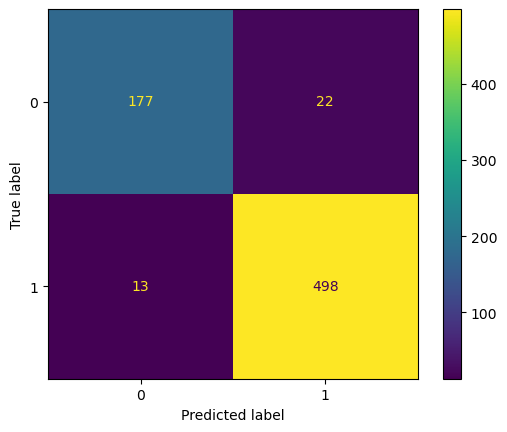

In [37]:
# View confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds),
                             display_labels=gs.classes_)
disp.plot();

# Saving Figure to Images folder
plt.savefig('./Images/conf_matrix_cvec_mnnb')

**Calculating Metrics other than accuracy**

In [38]:
specificity =  tn / (tn + fp)
print('Specificity Score: ', specificity)
print('Recall Score: ', metrics.recall_score(y_test, preds))
print('Precision Score: ', metrics.precision_score(y_test, preds))
print('F1 Score: ', metrics.f1_score(y_test, preds))

Specificity Score:  0.8894472361809045
Recall Score:  0.974559686888454
Precision Score:  0.9576923076923077
F1 Score:  0.9660523763336566


| Metric                      | Score                |
|-----------------------------|----------------------|
| Specificity                 | 0.8894472361809045  |
| Sensitivity (Recall)        | 0.974559686888454   |
| Precision                   | 0.9576923076923077  |
| F1 Score                    | 0.9660523763336566  |


**Interpretation of the calculated metrics:**

*citation:* [towardsdatascience.com]('https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9')

* **Recall,** also known as sensitivity or true positive rate, represents the proportion of correctly predicted posts from a specific source out of all the posts that were from that source. A high recall score means we have minimized the number of false negatives. The model's recall score of 0.945 means the model correctly identifies the percentage of the posts that were truly from source 0.


* **Precision** is a good measure to determine, when the costs of False Positive is high. A high precision score indicates that when the model predicts a post to be from source 1, it is usually correct.
  
* **F1 scores**, also known as the harmonic mean, are a particularly helpful metric as they are a function of both recall and precision. A high F1 score tells us the model has high precision and high recall. This means the model is identifying the source correctly and minimizing misclassifications.

* **Specificity** represents the ability of the model to correctly identify posts from source 1 as being from source 1, relative to all the actual posts that are from source 1. A high specificity score indicates that the model has a strong ability to correctly identify posts from source 1, without mistakenly classifying too many posts from source 0 as being from source 1. This metric is particularly important when the cost of misclassifying posts from source 1 as source 0 is high.
  






#### ROC curve and AUC
*citation:* [medium.com]('https://medium.com/@shaileydash/understanding-the-roc-and-auc-intuitively-31ca96445c02')

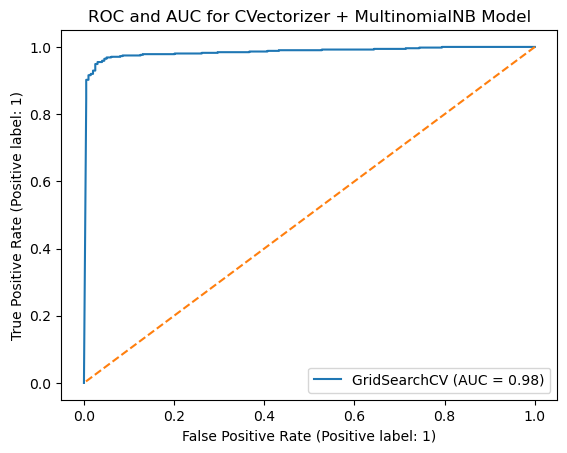

In [39]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

plt.title('ROC and AUC for CVectorizer + MultinomialNB Model')
plt.plot([1,0], [1,0], linestyle = '--')

# Saving Figure to Images folder
plt.savefig('./Images/roc_auc_cvec_mnnb')

**Interpretation & notes on ROC & AUC**

The ROC curve (Receiver Operating Characteristic curve) provides a visual insight into how well a binary classification model performs. Often considered the gold-standard.

An AUC (Area Under the Curve) of 0.99 indicates that the model effectively distinguishes posts from the target source. Ideally, a perfect AUC score of 1.0 would form an ROC curve with a 90° angle at the top left, signifying flawless performance.

The gold, dashed line is added to the graph to show the lowest performance a model could have when measured using this tool.

The model maintains a low false positive rate, meaning it rarely misclassifies posts from other sources as originating from the target source.